# TP1 - Graphs

In [2]:
import itertools
import networkx as nx
import matplotlib.pyplot as plt
from more_itertools import powerset
import time

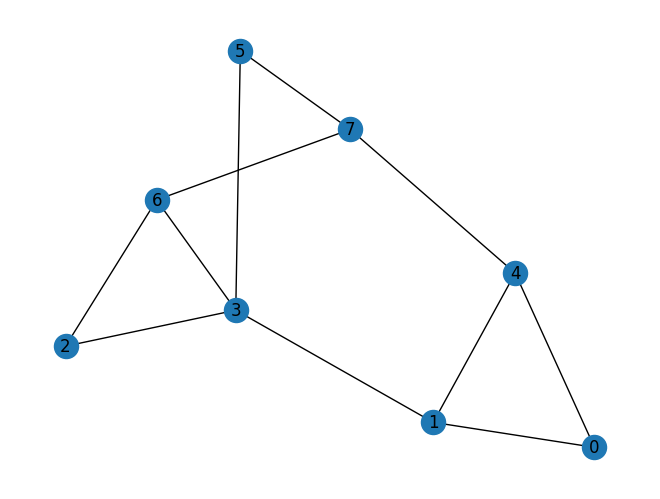

In [63]:
# use networkx to generate a random graph erdos_renyi_graph
G = nx.erdos_renyi_graph(8, 0.3, seed=1)
# use networkx to draw the graph
nx.draw(G, with_labels=True)
# show the graph
plt.show()

# Naive

```python
fonction recherche_clique(graphe G):
    n = nombre de sommets de G
    taille_max_clique = 0
    clique_max = ensemble vide
    
    pour chaque sous-ensemble S de sommets de G:
        si la taille de S > taille_max_clique et est_clique(G, S):
            taille_max_clique = taille de S
            clique_max = S
            
    retourner clique_max

fonction est_clique(graphe G, ensemble S):
    pour chaque paire de sommets v, w dans S:
        si v n'est pas adjacent à w dans G:
            retourner faux
    retourner vrai
```

In [4]:
def is_clique(G, S):
    for i in S:
        for j in S:
            if i != j and not G.has_edge(i, j):
                return False
    return True

def recherche_clique_naive(G):
    n = G.number_of_nodes()
    taille_max_clique = 0
    clique_max = set()
    
    for S in powerset(G.nodes()):
        if len(S) > taille_max_clique and is_clique(G, S):
            taille_max_clique = len(S)
            clique_max = S
            
    return clique_max

In [ ]:
start_time = time.time()
clique_max = recherche_clique_naive(G)
print("Clique max (naive):", clique_max)
print("Temps d'exécution (naive):", time.time() - start_time)

In [6]:
clique_max_netx = nx.approximation.max_clique(G)
print("Clique max (networkx):", clique_max_netx)

Clique max (networkx): {2, 68, 165, 137, 185, 63}


# Bron Kerbosch 

```python
algorithme BronKerbosch1(R, P, X)
    si P et X sont vides alors
        déclarer que R est une clique maximale
    pour tout sommet v dans P faire
        BronKerbosch1(R ⋃ {v}, P ⋂ N(v), X ⋂ N(v))
        P := P \ {v}
        X := X ⋃ {v}

BronKerbosch1(∅, V, ∅) //appel initial
```

In [7]:
def bron_kerbosh1(R, P, X, G):
    if not P and not X:
        return [R]
    else:
        cliques = []
        for v in P.copy():
            N = G.neighbors(v)
            cliques.extend(
                bron_kerbosh1(
                    R.union({v}),
                    P.intersection(N),
                    X.intersection(N),
                    G,
                )
            )
            P.remove(v)
            X.union({v})
        return cliques

def search_clique_bron_kerbosh1(G):
    return max(bron_kerbosh1(set(), set(G.nodes()), set(), G), key=len)

In [ ]:
clique_max = search_clique_bron_kerbosh1(G)
print("Clique max (bron_kerbosh1):", clique_max)
print("Clique max (networkx):", clique_max_netx)

Clique max (bron_kerbosh1): {0, 1, 14}
Clique max (networkx): {0, 1, 14}


# Bron Kerbosch pivot

```python
algorithme BronKerbosch2(R, P, X)
    si P et X sont vides alors
        déclarer que R est une clique maximale
    choisir un sommet pivot u dans P ⋃ X
    pour tout sommet v dans P \ N(u) faire
        BronKerbosch2(R ⋃ {v}, P ⋂ N(v), X ⋂ N(v))
        P := P \ {v}
        X := X ⋃ {v}
```

In [10]:
def bron_kerbosh2(R, P, X, G):
    if not P and not X:
        return [R]
    pivot = P.union(X).pop()  # TODO: compare both pivots
    pivot = max(P.union(X), key=G.degree)
    N = G.neighbors(pivot)
    cliques = []
    for v in P.difference(N):
        N_v = G.neighbors(v)
        cliques.extend(
            bron_kerbosh2(
                R.union({v}),
                P.intersection(N_v),
                X.intersection(N_v),
                G,
            )
        )
        P.remove(v)
        X.union({v})

    return cliques

def search_clique_bron_kerbosh2(G):
    return max(bron_kerbosh2(set(), set(G.nodes()), set(), G), key=len)

In [ ]:
clique_max = search_clique_bron_kerbosh2(G)
print("Clique max (bron_kerbosh1):", clique_max)
print("Clique max (networkx):", clique_max_netx)

Clique max (bron_kerbosh1): {0, 1, 14}
Clique max (networkx): {0, 1, 14}


# Bron Kerbosch pivot et dégénérescence

```python
algorithme BronKerbosch3(G)
    P = V(G)
    R = Ø
    X = Ø
    pour tout sommet v visités dans un ordre de dégénérescence de G faire
        BronKerbosch2({v}, P ⋂ N(v), X ⋂ N(v))
        P := P \ {v}
        X := X ⋃ {v}
```

## Dégénérescence

- Initialiser la liste de sortie L à la liste vide.
- Calculer une valeur dv pour chaque sommet v de G, qui est le nombre de voisins de v qui n'est pas déjà dans L (initialement, il s'agit donc du degré des sommets dans G).
- Initialiser un tableau D tel que D[i] contienne la liste des sommets v qui ne sont pas déjà dans L pour lesquels dv = i.
- Initialiser la valeur k à 0.
- Répéter n fois:
    - Parcourir les cellules du tableau D[0], D[1], ... jusqu'à trouver un i pour lequel D[i] est non-vide.
    - Mettre k à max(k,i).
    - Sélectionner un sommet v de D[i], ajouter v en tête de L et le retirer de D[i].
    - Pour chaque voisin w de v qui n'est pas déjà dans L, retirer une unité de dw et déplacer w de la cellule de D correspondant à la nouvelle valeur de dw.

In [9]:
def degen(G):
    ordering = []
    deg = dict(G.degree())
    while deg:
        v = min(deg, key=deg.get)
        ordering.append(v)
        del deg[v]
        for w in G.neighbors(v):
            if w in deg:
                deg[w] -= 1
    return ordering


def bron_kerbosh3(G):
    R = set()
    P = set(G.nodes())
    X = set()
    cliques = []
    for v in degen(G):
        N = G.neighbors(v)
        cliques.extend(
            bron_kerbosh2(
                R.union({v}),
                P.intersection(N),
                X.intersection(N),
                G,
            )
        )
        P.remove(v)
        X.union({v})
    return cliques

def search_clique_bron_kerbosh3(G):
    return max(bron_kerbosh3(G), key=len)

In [ ]:
clique_max = search_clique_bron_kerbosh3(G)
print("Clique max (bron_kerbosh1):", clique_max)

clique_max_netx = nx.approximation.max_clique(G)
print("Clique max (networkx):", clique_max_netx)

Clique max (bron_kerbosh1): {16, 26, 116, 196, 115, 120, 58}
Clique max (networkx): {2, 68, 165, 137, 185, 63}


# Parallélisation

### Naive solution

In [ ]:
import threading
import queue
import os
from concurrent.futures import ThreadPoolExecutor, as_completed

def is_clique(G, S):
    for i in S:
        for j in S:
            if i != j and not G.has_edge(i, j):
                return (False, S, 0)
    return (True, S, len(S))

def wrapper(arg):
    return is_clique(*arg)

def recherche_clique_naive_pool(G):
    n = G.number_of_nodes()
    taille_max_clique = 0
    clique_max = set()
    
    with ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
        futures = [executor.submit(wrapper, (G, S)) for S in powerset(G.nodes())]
        for future in as_completed(futures):
            l = future.result()[2]
            S = future.result()[1]
            if l > taille_max_clique:
                taille_max_clique = l
                clique_max = S
            
    return clique_max

In [ ]:
%%time
clique_max = recherche_clique_naive_pool(G)
print("Clique max (naive):", clique_max)

Clique max (naive): (0, 1, 10, 17)
CPU times: user 10.5 s, sys: 3.18 s, total: 13.7 s
Wall time: 14.5 s


In [ ]:
clique_max_netx = nx.approximation.max_clique(G)
print("Clique max (networkx):", clique_max_netx)

### Bron Kerbosch + degenerescence

In [10]:
from concurrent.futures import ThreadPoolExecutor, as_completed
import os

def bron_kerbosh3_pool(G):
    R = set()
    P = set(G.nodes())
    X = set()
    cliques = []
    with ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
        futures = [executor.submit(bron_kerbosh2, R.union({v}), P.intersection(G.neighbors(v)), X.intersection(G.neighbors(v)), G) for v in degen(G)]
        for future in as_completed(futures):
            cliques.extend(future.result())
    return cliques

def search_clique_bron_kerbosh3_pool(G):
    return max(bron_kerbosh3_pool(G), key=len)

In [11]:
clique_max = search_clique_bron_kerbosh3_pool(G)
print("Clique max (bron_kerbosh3):", clique_max)
print("Clique max (networkx):", clique_max_netx)

Clique max (bron_kerbosh3): {16, 26, 116, 196, 115, 120, 58}
Clique max (networkx): {2, 68, 165, 137, 185, 63}


## PySpark

In [6]:
import pyspark as ps

### Naive solution

In [13]:
import pyspark as ps

def is_clique(G, S):
    for i in S:
        for j in S:
            if i != j and not G.has_edge(i, j):
                return False
    return True

def recherche_clique_naive_spark(G):
    clique_max = set()

    sc = ps.SparkContext('local[4]')
    start_time = time.time()
    try:
        rdd = sc.parallelize(list(powerset(G.nodes())))
        rdd = rdd.map(lambda S: (len(S), S))
        rdd = rdd.filter(lambda x: is_clique(G, x[1]))
        clique_max = rdd.max(key=lambda x: x[0])[1]
        print("Temps d'exécution (naive):", time.time() - start_time)
    except Exception as e:
        sc.stop()
        return {}
    sc.stop()
    
    return clique_max

In [14]:
clique_max = recherche_clique_naive_spark(G)
print("Clique max (naive):", clique_max)

23/11/15 14:30:40 WARN Utils: Your hostname, MacBook-Pro-de-FISCH.local resolves to a loopback address: 127.0.0.1; using 10.41.174.7 instead (on interface en0)
23/11/15 14:30:40 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/15 14:30:41 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


: 

### Bron Kerbosch + degenerescence

In [35]:
def bron_kerbosh3_spark(G):
    R = set()
    P = set(G.nodes())
    X = set()
    cliques = []
    sc = ps.SparkContext('local[4]')
    try:
        for v in degen(G):
            N = G.neighbors(v)
            rdd = sc.parallelize([R.union({v})])
            rdd = rdd.map(lambda R: bron_kerbosh2(R, P.intersection(N), X.intersection(N), G))

            collect = rdd.collect()
            for c in collect:
                cliques.extend(c)
            P.remove(v)
            X.union({v})
    except Exception as e:
        sc.stop()
        return {}
    sc.stop()
    return cliques

def search_clique_bron_kerbosh3_spark(G):
    return max(bron_kerbosh3_spark(G), key=lambda x: len(x))

In [ ]:
clique_max = search_clique_bron_kerbosh3_spark(G)
print("Clique max (bron_kerbosh3):", clique_max)
print("Clique max (networkx):", clique_max_netx)

In [74]:
def bron_kerbosch_pivot(R, P, X, G):
    if not P and not X:
        return [R]
    else:
        cliques = []
        pivot = max(P.union(X), key=G.degree)
        for v in P.copy().difference(set(G.neighbors(pivot))):
            N = set(G.neighbors(v))
            cliques += bron_kerbosch_pivot(
                R.union({v}),
                P.intersection(N),
                X.intersection(N),
                G
            )

            P.remove(v)
            X.add(v)
        
        return cliques

def bron_kerbosch_map(G):
    map = [set(G.neighbors(v)).union({v}) for v in G.nodes()]
    return [set(s) for s in map]

def bron_kerbosch_reduce(x, y):
    return max(x, y, key=len)

try:
    sc = ps.SparkContext('local[*]')

    rdd = sc.parallelize(bron_kerbosch_map(G))\
            .flatMap(lambda x: bron_kerbosch_pivot(set(), x, set(), G))\
            .reduce(bron_kerbosch_reduce)
    print(rdd)
    sc.stop()
except Exception as e:
    print(e)
    sc.stop()

{0, 1, 4}


In [76]:
def bron_kerbosch_pivot(R, P, X, graph_broadcast):
    if not P and not X:
        yield tuple(R)  # Convert set R to a tuple before yielding
    else:
        u = max(P.union(X), key=lambda v: len(graph_broadcast.value[v]))
        for v in P - set(graph_broadcast.value[u]):
            yield from bron_kerbosch_pivot(
                R.union([v]),
                P.intersection(graph_broadcast.value[v]),
                X.intersection(graph_broadcast.value[v]),
                graph_broadcast
            )
            P.remove(v)
            X.add(v)

In [77]:
def parallel_bron_kerbosch3(sc, graph):
    graph_dict = {node: set(neighbors) for node, neighbors in nx.to_dict_of_dicts(graph).items()}
    graph_broadcast = sc.broadcast(graph_dict)
    ordering = degen(graph)

    # Parallelize the execution using the degeneracy ordering
    cliques_rdd = sc.parallelize(ordering).flatMap(
        lambda v: bron_kerbosch_pivot(
            {v},
            set(graph_dict[v]),
            set(),
            graph_broadcast
        )
    ).reduce(lambda x, y: max(x, y, key=len))
    return cliques_rdd

In [80]:
sc = ps.SparkContext('spark://10.41.173.158:7077')

cliques = parallel_bron_kerbosch3(sc, G)
print(cliques)
sc.stop()

(0, 1, 4)


In [79]:
sc.stop()